A 2D Fjord Ecosystem Model
==============================

Now that we have an NPZ model that characterizes the water column of the fjord, we now aim to add advection and diffusion along with a spatial grid of our region. This requires that we reformulate our equations to handle advection and diffusion and biological processes at each time-step.

\begin{equation}
\begin{split}
\frac{\partial N}{\partial t} + u\frac{\partial N}{\partial x}+v\frac{\partial N}{\partial y}+w(N'-N_s)&=A_T\nabla^2 N \nonumber - \frac{V_m N}{k_s+N}P+mP+gZ+\gamma R_m\Lambda P(1-e^{-\Lambda P})Z+\beta B \hspace{1.5in}(1)\\
\frac{\partial P}{\partial t} + u\frac{\partial P}{\partial x}+v\frac{\partial P}{\partial y}&=A_T\nabla^2 P  + \frac{V_m N}{k_s+N}P-mP-R_m\Lambda P(1-e^{-\Lambda P})Z-\alpha P \hspace{2in}(2)\\
\frac{\partial Z}{\partial t} + u\frac{\partial Z}{\partial x}+v\frac{\partial Z}{\partial y}&=A_T\nabla^2 Z  + (1-\gamma)R_m\Lambda P(1-e^{-\Lambda P})Z - gZ \hspace{2.75in}(3) \\
\frac{dB}{dt} & = \alpha P - \beta B. \hspace{5in}(4)
\end{split}
\end{equation}

*Note*: We do not employ advection and diffusion for the benthos as it is not moving on the time-scales we are concerned with.


We are going to load a data file that includes a grid layout (identifies land, provides the geophysical coordinates, etc.) along with time and space fields of water velocity.

| Parameter | Description                                    | Value        |
|-----------|------------------------------------------------|--------------|
|  $V_m$    | Maximum $P$ growth rate                        | 2 day$^{-1}$ |
|  $k_s$    | Half-Saturation constant for $N$               | 1 $\mu$gN L$^{-1}$ |
|  $m$      | $P$ mortality rate                             | 0.1 day$^{-1}$ |
|  $\gamma$ | Unassimilated grazing fraction from ("messy eating" percentage) | 0.3 |
|  $R_m$    | Maximum $Z$ grazing rate                       | 1.5 day$^{-1}$ |
|  $\Lambda$| Ivlev constant                                 | 1 $\mu$gN L$^{-1}$ |
|  $g$      | $Z$ mortality rate                             | 0.2 day$^{-1}$ |
|  $\tau$   | Time-lag for enzyme response to food abundance | 4 days         |
|  $\eta$    | Fraction of unassimilated $P$ that sinks out of euphotic zone | 0.5 |
|  $\beta$  | Rate that $P$ is mixed out of euphotic zone    | 0.1 day$^{-1}$ |



Modules
------

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

##  Parameters

1. tstart: time to start model integration [days]
1. tend: time to end model integration [days]
1. min_N: minimum level of Nitrogen [$\mu$gN/L]
1. min_P: minimum level of PhytoPlankton [$\mu$gN/L]
1. min_Z: minimum level of ZooPlankton [$\mu$gN/L]

In [3]:
tstart=0
tend=50
min_N=0.001
min_P=0.001
min_Z=0.001

Problem 1
---------

Modify the model code to carry out the problems below.

Model Code
----------

Implement the NPZ-class model
    
*Input*

| Name | Description | Units |
|-----------|-------------|-------|
| `dt` | Time Steap | days
| `N0` | Initial Nutrients | $\mu$gN L$^{-1}$
| `P0` | Initial Phytoplankton | $\mu$gN L$^{-1}$
| `Z0` | Initial Zooplankton | $\mu$gN L$^{-1}$
| `Vm` | Maximum P growth rate | days$^{-1}$
| `ks` | Half-saturation constant | $\mu$gN L$^{-1}$
| `m`  | Mortality-rate for phytoplankton | days$^{-1}$
| `gamma` | Messy Eating  | fraction
| `Rm` | Maximum Z grazing | days$^-1$
| `ivlev` | Ivlev constant  | $\mu$gN L$^{-1}$
| `g` | Z mortality rate | days$^{-1}$
| `tau` | Enzymatic time-lag | days
| `eta` | Fraction of $P$ that sink | fraction
| `beta` | mixing rate | days$^{-1}$
| `stable` | Use explicit [False] or semi-implicit [True] | bool

*Output*

| Name | Description | Units |
|-----------|-------------|-------|
| `times` | array of times, $t$ | days
| `N` | array of nutrients, $N(t)$| $\mu$gN L$^{-1}$
| `P` | array of Phytoplankton, $P(t)$ | $\mu$gN L$^{-1}$
| `Z` | array of Zooplankton, $Z(t)$ | $\mu$gN L$^{-1}$

In [4]:
def npz(dt=1e-3, N0=1.6, P0=0.3, Z0=0.1, Vm=2.0, ks=1.0, m=0.1, gamma=0.3, Rm=1.5, ivlev=1.0, 
        g=0.2, tau=4, eta=0.5, beta=0.1, adapt=True, mixing=False):

    # Create the variables to store our results
    times=np.arange(tstart, tend+dt, dt)  # Create the array of model times
    Nt=len(times)                         # Number of time-steps
    N=np.zeros(Nt)                        # Create the array for our nitrate with time
    P=np.zeros(Nt)                        # Create the array for our phytoplankton with time
    Z=np.zeros(Nt)                        # Create the array for our zooplankton with time
    A=np.zeros(Nt)                        # Create the array for our enzyme-rate with time

    # Set our initial conditions
    N[0]=N0
    P[0]=P0
    Z[0]=Z0
    A[0]=0.0
    
    # Loop over all of our times and integrate the model
    for n in range(Nt-1):
        # Calculate the terms of our system of equations
        uptake = Vm*P[n]*N[n] / (ks+N[n])
        pmortality = m*P[n]
        if adapt:
            graze = A[n] * (1.0-np.exp(-ivlev*P[n])) * Z[n]
        else:
            graze = ivlev * P[n] * Rm * (1.0-np.exp(-ivlev*P[n])) * Z[n]
        zmortality = g*Z[n]
        mix = beta*P[n]

        # Time-step the equations
        N[n+1] = N[n] + dt * ( -uptake + pmortality + zmortality + gamma*graze )
        if mixing:
            N[n+1] += dt * mix
        P[n+1] = P[n] + dt * ( uptake - pmortality - graze - mix )
        Z[n+1] = Z[n] + dt * ( (1-gamma)*graze - zmortality )
        A[n+1] = A[n] + dt * ( (ivlev*Rm*P[n] - A[n])/tau )

        # Apply the boundary checks
        N[n+1] = np.maximum(N[n+1], min_N)
        P[n+1] = np.maximum(P[n+1], min_P)
        Z[n+1] = np.maximum(Z[n+1], min_Z)

    return times, N, P, Z, A

Problem 3 
---------

The enzymes within the digestive tract of herbivorous zooplankton may adapt to a greater food abundance by increasing their concentration (allowing for more consumption). Previously, such acclimation would occur instantly, but we add a time-lag, $\tau$, between the increased food abundance and enzyme response. Franks, et al (1986) proposed to model this with an additional expression for the ingestion rate, $A(t)$, in the zooplankton grazing terms according to:

\begin{equation}
\begin{split}
\frac{dP}{dt} & = \frac{V_m N}{k_s+N}P-mP-A\left(1-e^{-\Lambda P}\right)Z \\
\frac{dZ}{dt} & = (1-\gamma)A\left(1-e^{-\Lambda P}\right)Z - gZ \\
\frac{dN}{dt} & = -\frac{V_m N}{k_s+N}P+mP+gZ+\gamma A\left(1-e^{-\Lambda P}\right)Z \\
\frac{dA}{dt} & = \frac{\Lambda R_m P - A}{\tau}.
\end{split}
\end{equation}

Alter your $NPZ$ model from HW3 to include the enzymatic response using the parameters from the table, a timestep of $\Delta t=10^{-3}$ days, and initial conditions of: $N(0)=1.6$ $\mu$gN L$^{-1}$, $P(0)=0.3$ $\mu$gN L$^{-1}$, $Z(0)=0.1$ $\mu$gN L$^{-1}$, and $A(0)=0$ $\mu$gN L$^{-1}$.

Run the *explicit* model for 50 days using Mayzaud-Poulet and plot the following: (i) timeseries of $P(t), Z(t)$, and $N(t)$ on the same plot; and, (ii) $Z(t)$ versus $P(t)$.  Compare your results with Problem 6 of Homework 3.


Text(0,0.5,'P [$\\mu$ g N L$^{-1}$]')

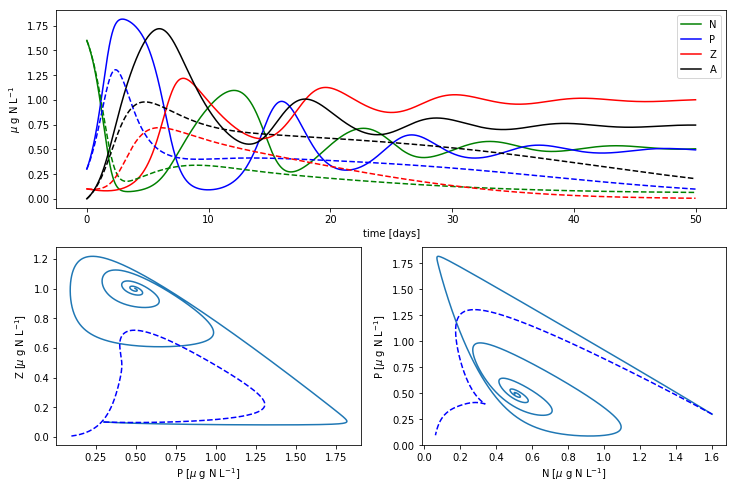

In [5]:
times,N,P,Z,A=npz(beta=0)
_,Na,Pa,Za,Aa=npz(adapt=False)

fig = plt.figure(figsize=(12,8))
ax = [0, 0, 0]
ax[0] = plt.subplot2grid((2,2), (0,0), colspan=2)
ax[1] = plt.subplot2grid((2,2), (1,0))
ax[2] = plt.subplot2grid((2,2), (1,1))

ax[0].plot(times,N,'g',times,P,'b',times,Z,'r',times,A,'k')
ax[0].plot(times,Na,'g--',times,Pa,'b--',times,Za,'r--',times,Aa,'k--')
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("$\mu$ g N L$^{-1}$")
ax[0].legend(["N","P","Z","A"])

ax[1].plot(P,Z)
ax[1].plot(Pa,Za,'b--')
ax[1].set_xlabel("P [$\mu$ g N L$^{-1}$]")
ax[1].set_ylabel("Z [$\mu$ g N L$^{-1}$]")

ax[2].plot(N,P)
ax[2].plot(Na,Pa,'b--')
ax[2].set_xlabel("N [$\mu$ g N L$^{-1}$]")
ax[2].set_ylabel("P [$\mu$ g N L$^{-1}$]")

## Results#



Problem 4
---------

Vertical mixing in the upper ocean can mix $P$ out of the euphotic zone where they can no longer photosynthesize and die (we assume). We wish to modify our model with an additional parameter, $\beta$, which characterizes the amount of $P$ that is mixed by the ocean out of the euphotic zone. We modify our $P$ rate equation as:

$$\frac{dP}{dt} = \frac{V_mN}{k_s+N}P-mP-A\left(1-e^{-\Lambda P}\right)Z - \beta P$$


Modify your model from Problem 2 and integrate again. Compare to the results of Problems 2 and 3. How does each term affect the spring bloom and the response? How has the system **fundamentally** changed? Vary $\beta$ and explain how the results change.



Text(0,0.5,'P [$\\mu$ g N L$^{-1}$]')

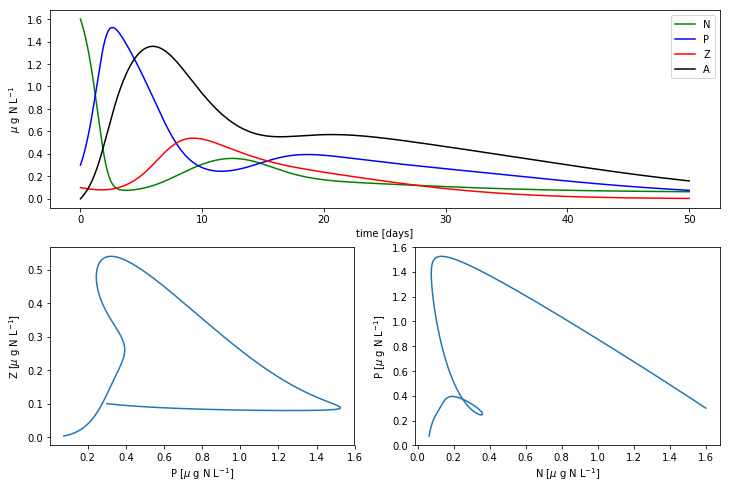

In [9]:
times,N,P,Z,A=npz()

fig = plt.figure(figsize=(12,8))
ax = [0, 0, 0]
ax[0] = plt.subplot2grid((2,2), (0,0), colspan=2)
ax[1] = plt.subplot2grid((2,2), (1,0))
ax[2] = plt.subplot2grid((2,2), (1,1))

ax[0].plot(times,N,'g',times,P,'b',times,Z,'r',times,A,'k')
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("$\mu$ g N L$^{-1}$")
ax[0].legend(["N","P","Z","A"])

ax[1].plot(P,Z)
ax[1].set_xlabel("P [$\mu$ g N L$^{-1}$]")
ax[1].set_ylabel("Z [$\mu$ g N L$^{-1}$]")

ax[2].plot(N,P)
ax[2].set_xlabel("N [$\mu$ g N L$^{-1}$]")
ax[2].set_ylabel("P [$\mu$ g N L$^{-1}$]")

## Results#



Problem 5 [OCN 681 Only]
------------------------

Just as vertical mixing can take away phytoplankton, vertical mixing (upwelling) can bring nutrients back up from the reservoir into the euphotic zone. For these tests, let us assume that the additional nutrients are due to the $P$ that was mixed away, such that:

$$\frac{dN}{dt} = -\frac{V_mN}{k_s+N}P+mP+gZ+\gamma A\left(1-e^{-\Lambda P}\right)Z + \beta P$$

Modify your model from Problem 3 and integrate again. Compare to the results of Problems 2, 3, and 4. How has the system **fundamentally** changed again? How does each term affect the spring bloom and the response? Vary $\beta$ again and compare to values from Problem 3.

Text(0,0.5,'P [$\\mu$ g N L$^{-1}$]')

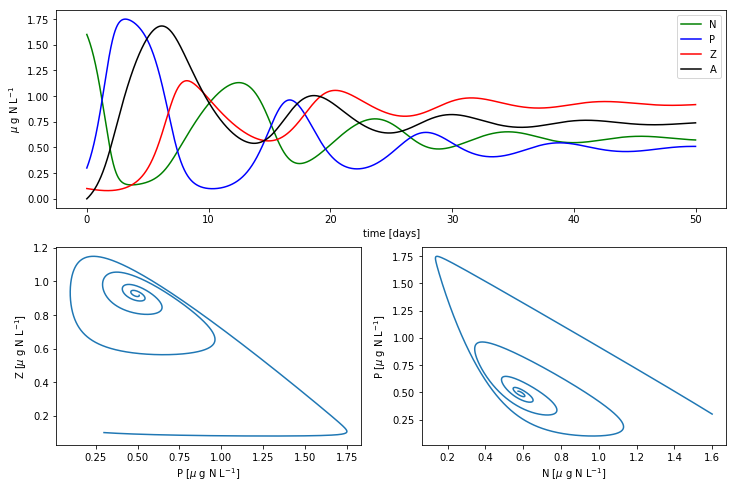

In [10]:
times,N,P,Z,A=npz(mixing=True)

fig = plt.figure(figsize=(12,8))
ax = [0, 0, 0]
ax[0] = plt.subplot2grid((2,2), (0,0), colspan=2)
ax[1] = plt.subplot2grid((2,2), (1,0))
ax[2] = plt.subplot2grid((2,2), (1,1))

ax[0].plot(times,N,'g',times,P,'b',times,Z,'r',times,A,'k')
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("$\mu$ g N L$^{-1}$")
ax[0].legend(["N","P","Z","A"])

ax[1].plot(P,Z)
ax[1].set_xlabel("P [$\mu$ g N L$^{-1}$]")
ax[1].set_ylabel("Z [$\mu$ g N L$^{-1}$]")

ax[2].plot(N,P)
ax[2].set_xlabel("N [$\mu$ g N L$^{-1}$]")
ax[2].set_ylabel("P [$\mu$ g N L$^{-1}$]")

## Results#

